In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Natural Language Processing with Disaster Tweets

Bu projede verilen tweetin gerçek bir felaketle ilgili olup olmadığını tahmin eden sınıflandırma modeli geliştirilmektedir.

Projede kullanılan veriler [buradan](https://www.kaggle.com/competitions/nlp-getting-started/data) temin edilmiştir.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df=pd.concat([train,test], ignore_index=True)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


In [6]:
train.shape, test.shape

((7613, 5), (3263, 4))

<Axes: ylabel='count'>

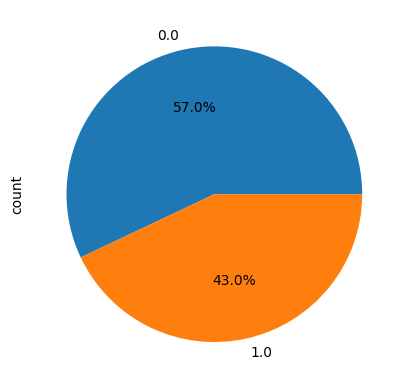

In [7]:
df["target"].value_counts().plot.pie(autopct="%1.1f%%")

## Metin Temizleme

In [8]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [9]:
def clean_text(text):
    #text = BeautifulSoup(text).get_text() 
    text=text.str.lower()
    text=text.str.replace('[^\w\s]', '', regex=True)
    text=text.str.replace('\d+', '', regex=True)
    text=text.str.replace('\n', '', regex=True)
    text=text.str.replace('\r', '', regex=True)
    return text

In [10]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [24]:
vect=CountVectorizer(stop_words="english", ngram_range=(1,2), analyzer=lemmafn, max_features=10000)

# ML Modelleme

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

b = BernoulliNB()
l = LogisticRegression()
d = DecisionTreeClassifier()
r = RandomForestClassifier()
gb= GradientBoostingClassifier()
kn= KNeighborsClassifier()
ab= AdaBoostClassifier()
mn= MultinomialNB()

def algo_test(x, y):
    modeller=[ b, l, d, r, gb, kn, ab, mn]
    isimler=["BernoulliNB", "LogisticRegression", "DecisionTreeClassifier", 
             "RandomForestClassifier", "GradientBoostingClassifier", "KNeighborsClassifier",
             "AdaBoostClassifier", "MultinomialNB"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state = 42)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    mdl=[]

    print("Veriler hazır modeller deneniyor")
    for model in modeller:
        print(model, " modeli eğitiliyor!..")
        model=model.fit(x_train,y_train)
        tahmin=model.predict(x_test)
        mdl.append(model)
        accuracy.append(accuracy_score(y_test, tahmin))
        precision.append(precision_score(y_test, tahmin, average="micro"))
        recall.append(recall_score(y_test, tahmin, average="micro"))
        f1.append(f1_score(y_test, tahmin, average="micro"))
        print(confusion_matrix(y_test, tahmin))

    print("Eğitim tamamlandı.")
    
    metrics=pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1", "Model"], index=isimler)
    metrics["Accuracy"] = accuracy
    metrics["Precision"] = precision  
    metrics["Recall"] = recall
    metrics["F1"] = f1
    metrics["Model"]=mdl

    metrics.sort_values("F1", ascending=False, inplace=True)

    print("En başarılı model: ", metrics.iloc[0].name)
    model=metrics.iloc[0,-1]
    tahmin=model.predict(np.array(x_test) if model==kn else x_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, tahmin))
    print("classification Report:")
    print(classification_report(y_test, tahmin))
    print("Diğer Modeller:")
    
    return metrics.drop("Model", axis=1)

In [13]:
df["text"]=clean_text(df["text"])

In [14]:
train.shape[0]

7613

In [15]:
train=df.iloc[:train.shape[0]]
test=df.iloc[train.shape[0]:]
train.shape, test.shape

((7613, 5), (3263, 5))

In [25]:
x=np.array(train["text"])
y=np.array(train["target"])

In [26]:
x=vect.fit_transform(x)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [27]:
algo_test(x,y)

Veriler hazır modeller deneniyor
BernoulliNB()  modeli eğitiliyor!..
[[1209  109]
 [ 315  651]]
LogisticRegression()  modeli eğitiliyor!..
[[1152  166]
 [ 278  688]]
DecisionTreeClassifier()  modeli eğitiliyor!..
[[1026  292]
 [ 345  621]]
RandomForestClassifier()  modeli eğitiliyor!..
[[1206  112]
 [ 349  617]]
GradientBoostingClassifier()  modeli eğitiliyor!..
[[1171  147]
 [ 422  544]]
KNeighborsClassifier()  modeli eğitiliyor!..
[[1261   57]
 [ 712  254]]
AdaBoostClassifier()  modeli eğitiliyor!..
[[1186  132]
 [ 434  532]]
MultinomialNB()  modeli eğitiliyor!..
[[1165  153]
 [ 287  679]]
Eğitim tamamlandı.
En başarılı model:  BernoulliNB
Confusion Matrix:
[[1209  109]
 [ 315  651]]
classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1318
         1.0       0.86      0.67      0.75       966

    accuracy                           0.81      2284
   macro avg       0.82      0.80      0.80      2284
weighted a

,Accuracy,Precision,Recall,F1
BernoulliNB,0.814361,0.814361,0.814361,0.814361
MultinomialNB,0.807356,0.807356,0.807356,0.807356
LogisticRegression,0.805604,0.805604,0.805604,0.805604
RandomForestClassifier,0.798161,0.798161,0.798161,0.798161
AdaBoostClassifier,0.752189,0.752189,0.752189,0.752189
GradientBoostingClassifier,0.750876,0.750876,0.750876,0.750876
DecisionTreeClassifier,0.721103,0.721103,0.721103,0.721103
KNeighborsClassifier,0.663310,0.663310,0.663310,0.663310


In [28]:
br=BernoulliNB()
br_model=br.fit(x,y)

In [29]:
x_test=np.array(test["text"])
x_test=vect.fit_transform(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [32]:
test["target"]=br_model.predict(x_test).astype(int)

/tmp/ipykernel_34/1025965816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target"]=br_model.predict(x_test).astype(int)


In [33]:
test.head()

,id,keyword,location,text,target
7613,0,NaN,NaN,just happened a terrible car crash,0
7614,2,NaN,NaN,heard about earthquake is different cities sta...,0
7615,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
7616,9,NaN,NaN,apocalypse lighting spokane wildfires,1
7617,11,NaN,NaN,typhoon soudelor kills in china and taiwan,0


In [34]:
test[["id", "target"]].to_csv("submission.csv", index=False)

## DL Modelleme

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

2024-05-30 15:00:54.251261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 15:00:54.251375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 15:00:54.422577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [37]:
x = train['text'].values
y = train['target'].values

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [39]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(x_train)

In [48]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [49]:
max_sequence_length = max([len(x) for x in x_train])
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [88]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=200, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(512, dropout=0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [89]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.6582 - loss: 0.6065 - val_accuracy: 0.7938 - val_loss: 0.4524
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8733 - loss: 0.3152 - val_accuracy: 0.7945 - val_loss: 0.4651
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9327 - loss: 0.1901 - val_accuracy: 0.7866 - val_loss: 0.6672
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9606 - loss: 0.1135 - val_accuracy: 0.7833 - val_loss: 0.8256
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9704 - loss: 0.0839 - val_accuracy: 0.7873 - val_loss: 0.9005
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9735 - loss: 0.0728 - val_accuracy: 0.7498 - val_loss: 0.8268
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9854 - loss: 0.0395 - val_accuracy: 0.7544 - val_loss: 0.9933
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9827 - loss: 0.0411 - 

In [90]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7311 - loss: 1.5482
Test Loss: 1.4945
Test Accuracy: 0.7459


In [91]:
xt = test['text'].values
xt = tokenizer.texts_to_sequences(xt)
xt = pad_sequences(xt, maxlen=max_sequence_length)

In [92]:
pred=model.predict(xt)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [93]:
pred2=[np.argmax(x) for x in pred]

In [94]:
test["target_dl"]=pred2
test.head()

/tmp/ipykernel_34/2566461662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["target_dl"]=pred2


,id,keyword,location,text,target,target_dl
7613,0,NaN,NaN,just happened a terrible car crash,0,1
7614,2,NaN,NaN,heard about earthquake is different cities sta...,0,1
7615,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1,1
7616,9,NaN,NaN,apocalypse lighting spokane wildfires,1,1
7617,11,NaN,NaN,typhoon soudelor kills in china and taiwan,0,1


In [95]:
test["target_dl"].value_counts()

target_dl
0    1929
1    1334
Name: count, dtype: int64

In [96]:
test[["id", "target_dl"]].rename(columns={"target_dl": "target"}).to_csv("submission_dl.csv", index=False)

## Sonuç:
Makine öğrenmesi modeli ile Kaggle Score: 0.49770 elde edildi. <br>
Ancak Derin öğrenme modeli ile Kaggle Score: 0.75022 elde edildi.